Libraries and Style Files
-------------------------

In [1]:
#we may need some code in the ../python directory and/or matplotlib styles
import sys
sys.path.append('../python/')

!pip install periodictable
!pip install pyteomics

#matplotlib for plotting
import matplotlib as mpl
from matplotlib import pyplot as plt
plt.style.use('../mplstyles/stylelib/standard.mplstyle')

import numpy as np
import pandas as pd
import scipy.constants as co
import ENDF6el as endfel
import masses as ms
import flux_recoil_spec as frs

Objective
-
This notebook builds upon the preceeding notebooks, namely `A-Differential-Neutron-Nucleus-XN.ipynb` and `B-Neutron-Nucleus-Recoil-Distributions.ipynb`. Our objective now is to obtain the neutron flux as a function of energy, reconcile that flux with the differential recoil energy cross section at each energy, and produce a realistic recoil energy distribution as it would appear in a detector.


Load Neutron Flux Data
-

In [2]:
import pandas as pd

fast_flux_df = pd.read_pickle('../data_files/FDF.txt')
print(fast_flux_df.head())

          E      spec
0  0.010000  0.000014
1  0.011665  0.000012
2  0.013330  0.000012
3  0.014995  0.000011
4  0.016660  0.000010


Calculate Differential Recoil Cross Section $\frac{d\sigma}{dE_r}(E_i,E_r)$
-
This section will allow us to determine the liklihood of a neutron with energy $E_i$ scattering off a nucleus and deposit a certain amount of recoil energy E_r. This likelihood is given by the differential cross section $\frac{d\sigma}{dE_r}(E_i,E_r)$. In the previous notebook, `B-Neutron-Nucleus-Recoil-Distributions.ipynb`, we developed code that calculates this value for specific energies. Now, we want to generalize it. The following section will provide us with the expected distribution of nuclear recoil energies measured by the detector.

Neutrons interact with detectors at differing initial energies ($E_n$), and the number of incident neutrons at a given specific energy is described by the neutron flux spectrum, $\Phi(E_n)$. These neutrons recoil at varying energies ($E_r$) depending on factors including their incident energy and the collision's differential cross section $\frac{d\sigma}{dE_r}(E_i,E_r)$. The total rate at which these recoils happen is found by summing the contribution from all differentiaal neutron energies that could cause a recoil of that amount. In other words, we must sum over all neutron energies that can produce a specific recoil energy. Hence, we integrate. We will use the following equation to calculate the differential event rate per unit recoil energy:

$$
\frac{dR}{dE_r} = \int_{E_n^{\text{min}}}^{E_n^{\text{max}}} \Phi(E_n) \cdot \frac{d\sigma}{dE_r}(E_n, E_r) \, dE_n
$$

Where:<br /><br />
$\frac{dR}{dE_r}$ is rate (per time, per mass) at which recoils of energy $E_r$ occur.<br />
$\Phi(E_n)$ is the flux at neutron energy $E_n$.<br />
$\frac{d\sigma}{dE_r}(E_n, E_r)$ is the differential recoil cross section at neutron energy $E_n$.

Thus, the integrand $\Phi(E_n) \cdot \frac{d\sigma}{dE_r}(E_n, E_r)$ gives us the rate at which neutrons of energy $E_n$ contribute to producing recoils of energy $E_r$.

fast flux: 4000.0000000000005 n/m^2/day
175
shape of etot: (6000,)
6000 6000
LinregressResult(slope=-0.34198906017016933, intercept=-12.883178144228596, rvalue=-0.9953352356165472, pvalue=2.8473572672917526e-06, stderr=0.01482451947661301, intercept_stderr=0.06273875262265731)
0.009998654133395216 0.01


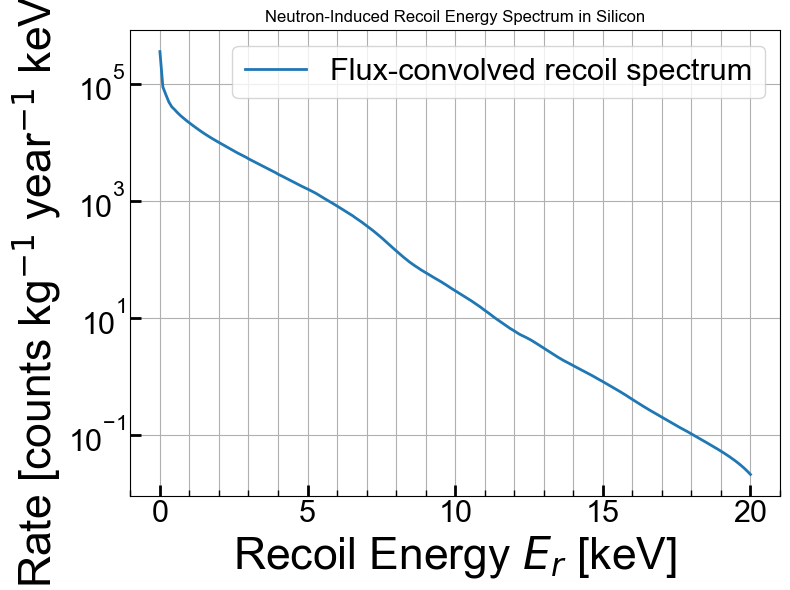

In [4]:
# Define realflux Function using SNOLAB_flux
from scipy.interpolate import interp1d

# Load flux from the frs module
E, F, *_ = frs.SNOLAB_flux()  # E: energy [MeV], F: flux [n/cm^2/s/MeV]

# Create an interpolator (flux as a function of neutron energy)
flux_interp = interp1d(E, F, bounds_error=False, fill_value=0.0)

# Define realflux function to wrap the interpolator
def realflux(En):
    return flux_interp(En)

# Define Constants
msi = 28.0855  # Silicon molar mass [g/mol]
NA = co.physical_constants['Avogadro constant'][0]  # Avogadro number

# Define Recoil Energy Range
erange = np.linspace(0.0, 20.0, 200)  # recoil energies in keV

# Define Integration Kernel
from scipy import integrate

def dsigdEr(En, Er):
    # En in keV, Er in keV
    return frs.dsigdErNE(En, Er)
        
def dru(Er):
    # Return dR/dEr at this Er [counts / g / s / keV]
    def integrand(En):
        flux = realflux(En)  # flux at neutron energy En [n/cm^2/s/MeV]
        sig = dsigdEr(En * 1000, Er)  # differential cross section in cm^2 / keV
        return flux * sig

    # integrate over neutron energies that could produce recoil Er
    En_min = frs.Enmin(Er) / 1000  # MeV
    En_max = 10  # max energy [MeV]

    integral, _ = integrate.quad(integrand, En_min, En_max, limit=1000)
    return 14 * (NA / msi) * integral

# Calculate Spectrum
dru_vec = np.array([dru(e) for e in erange])  # [counts / g / s / keV]

# Convert to DRU (counts per kg per year per keV)
conversion = 1000 * 365 * 24 * 60 * 60  # from g/s to kg/year
dru_vec_kg_yr = dru_vec * conversion

# Plot
plt.figure(figsize=(8,6))
plt.plot(erange, dru_vec_kg_yr, label='Flux-convolved recoil spectrum')
plt.yscale('log')
plt.xlabel('Recoil Energy $E_r$ [keV]')
plt.ylabel('Rate [counts kg$^{-1}$ year$^{-1}$ keV$^{-1}$]')
plt.title('Neutron-Induced Recoil Energy Spectrum in Silicon')
plt.grid(True, which='both')
plt.legend()
plt.tight_layout()
plt.show()